# STEP 1: Data Acquisition (can give more graph for this)

The initial phase involves establishing a connection to the SQLite database and retrieving the phishing website dataset. We first inspect the database structure to identify available tables, then load the relevant data into a pandas DataFrame for subsequent analysis. This structured approach ensures data integrity and provides a foundation for all subsequent analytical steps.

The dataset is now loaded and ready for comprehensive exploratory analysis.

### The conclusions and the interpretation

#### Data Quality Assessment and Initial Findings
Data Structure Overview
The dataset comprises 10,500 total entries with 16 features, including both numerical and categorical variables. The data types are appropriately assigned, with integer and float types for numerical features and object type for the categorical Industry variable. The target variable is also balanced since there are 55% of websites are being labelled as legitimate and 45% of websites are being labelled as phishing website.

#### Critical Data Quality Issues
Missing Values Identification:

LineOfCode contains 2,355 missing values (22.4% of total records)

All other features demonstrate complete data integrity with 10,500 non-null entries

Data Completeness Impact:
The significant missingness in LineOfCode presents a substantial data quality concern. This feature's partial availability may limit its utility in subsequent analysis and modeling phases. The handling strategy for these missing values will require careful consideration, potentially involving imputation techniques or exclusion from certain analyses.


#### Implications for Analysis Strategy
Data Preprocessing Requirements:
The identified data quality issues necessitate implementing rigorous preprocessing pipelines. Specific considerations include:

1. Development of appropriate missing data handling strategies for LineOfCode
2. Validation of data distributions for numerical features to identify potential outliers
3. Encoding schemes for categorical variables like Industry and binary features

In [43]:
# Standard library imports
import sqlite3

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Display plots inline
%matplotlib inline

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Connect to SQLite database
conn = sqlite3.connect('data/phishing.db')

# List all tables in the database
query_tables = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(query_tables, conn)
print("Available tables in the database:")
print(tables)

# Load the main dataset (assuming the table name is 'phishing_data')
table_name = 'phishing_data'  # Replace with actual table name from above output
df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)

# Close database connection
conn.close()

# Display basic dataset information
print(f"\nDataset shape: {df.shape}")
print("\nFirst 5 rows of the dataset:")
df.info()
print(df['label'].value_counts(normalize=True))

# remove unnamed column if exists
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

df.head()


Available tables in the database:
            name
0  phishing_data

Dataset shape: (10500, 16)

First 5 rows of the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10500 entries, 0 to 10499
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         10500 non-null  int64  
 1   LineOfCode         8145 non-null   float64
 2   LargestLineLength  10500 non-null  int64  
 3   NoOfURLRedirect    10500 non-null  int64  
 4   NoOfSelfRedirect   10500 non-null  int64  
 5   NoOfPopup          10500 non-null  int64  
 6   NoOfiFrame         10500 non-null  int64  
 7   NoOfImage          10500 non-null  int64  
 8   NoOfSelfRef        10500 non-null  int64  
 9   NoOfExternalRef    10500 non-null  int64  
 10  Robots             10500 non-null  int64  
 11  IsResponsive       10500 non-null  int64  
 12  Industry           10500 non-null  object 
 13  HostingProvider    10500 non-null  objec

,LineOfCode,LargestLineLength,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfSelfRef,NoOfExternalRef,Robots,IsResponsive,Industry,HostingProvider,DomainAgeMonths,label
0,NaN,9965,0,0,2,1,48,172,170,1,1,Fashion,DreamHost,98,0
1,769.0,9507,0,0,0,4,25,55,78,1,1,Fashion,AWS,31,1
2,720.0,2550,0,0,0,2,-31,94,13,0,1,Education,Google Cloud,26,1
3,198.0,869,0,0,0,0,0,0,2,0,0,Unknown,DreamHost,2,1
4,972.0,2807,0,0,0,2,6,83,51,0,1,Education,GoDaddy,43,1


# STEP 2: Missing Data Assessment
The LineOfCode feature contains 2,355 missing values, representing approximately 22.4% of the total dataset. Before implementing any handling strategy, it is crucial to understand the nature and pattern of these missing values.

### The conclusion and implication
Non-Random Missing Data Pattern
Based on the analysis results, we have identified a highly significant pattern in the missing data that requires specialized handling.

#### Missing Data Pattern Analysis
The analysis reveals a critical finding:
All missing LineOfCode values occur exclusively in phishing websites (label = 0)

Missingness as a Predictive Feature
The fact that missing LineOfCode data occurs exclusively in phishing websites transforms this data quality issue into a potentially powerful predictive feature. This pattern suggests:
1. Phishing websites may intentionally obfuscate or fail to provide code metrics
2. Technical limitations in data collection from malicious sites
3. Systematic differences in how phishing vs legitimate websites are structured
4. It is possible to create enhanced features that leverage this pattern for Feature Engineering Opportunity.

####  Strategy

1. Primary Approach: Use the class-specific median imputation with pattern preservation

2. Feature Inclusion: Retain both the imputed LineOfCode values and the missing indicator features

3. Model Interpretation: Document that missing LineOfCode is a strong indicator of phishing websites

4. Risk Assessment: Acknowledge that this pattern may reflect underlying data collection biases that should be considered in model deployment



In [44]:
# Analyze missing data pattern
missing_pattern = df[df['LineOfCode'].isnull()]
complete_pattern = df[df['LineOfCode'].notnull()]

print("Missing LineOfCode statistics:")
print(f"Total missing: {len(missing_pattern)}")
print(f"Percentage missing: {(len(missing_pattern)/len(df))*100:.1f}%")

# Check if missingness is related to other variables or random
print("\nMissing value pattern analysis:")
for column in ['label', 'Industry', 'IsResponsive']:
    missing_dist = missing_pattern[column].value_counts(normalize=True)
    complete_dist = complete_pattern[column].value_counts(normalize=True)
    print(f"\n{column} distribution comparison:")
    print("Missing data: ", missing_dist.head())
    print("Complete data: ", complete_dist.head())

Missing LineOfCode statistics:
Total missing: 2355
Percentage missing: 22.4%

Missing value pattern analysis:

label distribution comparison:
Missing data:  label
0    1.0
Name: proportion, dtype: float64
Complete data:  label
1    0.709515
0    0.290485
Name: proportion, dtype: float64

Industry distribution comparison:
Missing data:  Industry
eCommerce     0.286624
Unknown       0.170701
Education     0.146497
Non-profit    0.097665
Fashion       0.062420
Name: proportion, dtype: float64
Complete data:  Industry
eCommerce     0.226642
Non-profit    0.165746
Education     0.140086
Unknown       0.128177
Fashion       0.084960
Name: proportion, dtype: float64

IsResponsive distribution comparison:
Missing data:  IsResponsive
0    0.562633
1    0.437367
Name: proportion, dtype: float64
Complete data:  IsResponsive
1    0.677471
0    0.322529
Name: proportion, dtype: float64


# STEP 3: Missing Data Handling Strategy
The missing data handling strategy addresses systematic missingness in the LineOfCode feature while preserving its predictive value. The approach transforms a data quality issue into a strategic advantage for phishing detection.


### Critical Findings and Conclusions
1. Substantial Feature Disparity: Legitimate websites exhibit significantly higher median LineOfCode (888.0) compared to phishing sites (37.0), suggesting fundamental structural differences in website complexity.

2. Successful Resolution: The imputation strategy successfully handled all missing values while maintaining data integrity.

3. Analytical Implications
Predictive Feature Enhancement: The missingness pattern itself serves as a strong phishing indicator. The LineOfCode_Missing_Phishing feature provides direct discriminatory power for classification models.


In [45]:
def handle_missing_lineofcode_strategic(df):
    """
    Handle missing LineOfCode using class-specific imputation
    that preserves the missing data pattern as a feature
    """
    df_processed = df.copy()
    
    # Create comprehensive missing indicator
    df_processed['LineOfCode_Missing'] = df_processed['LineOfCode'].isnull().astype(int)
    
    # Calculate separate medians for each class
    median_phishing = df_processed[df_processed['label'] == 0]['LineOfCode'].median()
    median_legitimate = df_processed[df_processed['label'] == 1]['LineOfCode'].median()
    
    print(f"Median LineOfCode - Phishing sites: {median_phishing}")
    print(f"Median LineOfCode - Legitimate sites: {median_legitimate}")
    
    # Impute missing values with class-specific medians
    phishing_mask = (df_processed['LineOfCode'].isnull()) & (df_processed['label'] == 0)
    legitimate_mask = (df_processed['LineOfCode'].isnull()) & (df_processed['label'] == 1)
    
    df_processed.loc[phishing_mask, 'LineOfCode'] = median_phishing
    df_processed.loc[legitimate_mask, 'LineOfCode'] = median_legitimate
    
    # Create interaction feature that captures the pattern
    df_processed['LineOfCode_Missing_Phishing'] = (
        (df_processed['LineOfCode_Missing'] == 1) & 
        (df_processed['label'] == 0)
    ).astype(int)
    
    return df_processed

# Apply strategic imputation
df_final = handle_missing_lineofcode_strategic(df)

print(f"Original missing values: 2355")
print(f"Remaining missing values: {df_final['LineOfCode'].isnull().sum()}")
# Inspect the final dataset
df_final.head()

Median LineOfCode - Phishing sites: 37.0
Median LineOfCode - Legitimate sites: 888.0
Original missing values: 2355
Remaining missing values: 0


,LineOfCode,LargestLineLength,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfSelfRef,NoOfExternalRef,Robots,IsResponsive,Industry,HostingProvider,DomainAgeMonths,label,LineOfCode_Missing,LineOfCode_Missing_Phishing
0,37.0,9965,0,0,2,1,48,172,170,1,1,Fashion,DreamHost,98,0,1,1
1,769.0,9507,0,0,0,4,25,55,78,1,1,Fashion,AWS,31,1,0,0
2,720.0,2550,0,0,0,2,-31,94,13,0,1,Education,Google Cloud,26,1,0,0
3,198.0,869,0,0,0,0,0,0,2,0,0,Unknown,DreamHost,2,1,0,0
4,972.0,2807,0,0,0,2,6,83,51,0,1,Education,GoDaddy,43,1,0,0


# STEP4 Data Quality Assessment and Outlier Detection

This analysis systematically identifies data quality issues and potential outliers across all features to ensure robust model development and reliable analytical conclusions.



In [46]:
import scipy.stats as stats

# Check for mixed data types in categorical columns
categorical_columns = df_final.select_dtypes(include=['object']).columns
for col in categorical_columns:
    unique_types = df_final[col].apply(type).value_counts()
    if len(unique_types) > 1:
        print(f"Mixed types in {col}: {unique_types}")
        
# Analyze categorical variables for inconsistencies
print("\n=== CATEGORICAL DATA QUALITY ===")
categorical_issues = {}

for col in categorical_columns:
    value_counts = df_final[col].value_counts()
    unique_count = len(value_counts)
    
    print(f"\n{col}:")
    print(f"Unique values: {unique_count}")
    print(f"Top 5 values: {value_counts.head()}")
    
    # Flag potential issues
    if unique_count > 50:
        categorical_issues[col] = f"High cardinality: {unique_count} categories"
    if df_final[col].isnull().sum() > 0:
        categorical_issues[col] = f"Missing values: {df_final[col].isnull().sum()}"





=== CATEGORICAL DATA QUALITY ===

Industry:
Unique values: 11
Top 5 values: Industry
eCommerce     2521
Non-profit    1580
Education     1486
Unknown       1446
Fashion        839
Name: count, dtype: int64

HostingProvider:
Unique values: 13
Top 5 values: HostingProvider
Unknown Provider    1177
GoDaddy              940
Bluehost             908
HostGator            885
Freehostia           805
Name: count, dtype: int64


Categorical Data Analysis
Industry Distribution:

Data Quality: Good - 11 unique categories indicates manageable cardinality

Pattern Analysis:

"eCommerce" is the most frequent industry (24.0%)

Significant "Unknown" category presence (13.8%) - may require special handling

Distribution appears reasonable for website classification

Hosting Provider Distribution:

Data Quality: Good - 13 unique providers suggests appropriate granularity

Critical Finding: "Unknown Provider" is the most common (11.2%)

This may indicate data collection limitations or privacy-conscious websites

Could be meaningful for phishing detection (obfuscated hosting)



In [47]:
import scipy.stats as stats

def detect_numerical_outliers(df, columns):
    """
    Comprehensive outlier detection using multiple methods
    """
    outlier_flags = pd.DataFrame(index=df.index)
    
    for col in columns:
        # Method 1: IQR (Interquartile Range)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        iqr_outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
        
        # Method 2: Z-score (for normally distributed data)
        z_scores = stats.zscore(df[col].dropna())
        z_outliers = np.abs(z_scores) > 3
        
        # Method 3: Percentile-based (robust for skewed data)
        p01 = df[col].quantile(0.01)
        p99 = df[col].quantile(0.99)
        percentile_outliers = (df[col] < p01) | (df[col] > p99)
        
        # Combine flags
        outlier_flags[f'{col}_outlier'] = iqr_outliers | z_outliers | percentile_outliers
        
        # Report findings
        outlier_count = outlier_flags[f'{col}_outlier'].sum()
        if outlier_count > 0:
            print(f"{col}: {outlier_count} outliers detected "
                  f"({outlier_count/len(df)*100:.1f}%)")
            print(f"  Range: [{df[col].min():.0f}, {df[col].max():.0f}] "
                  f"| IQR bounds: [{lower_bound:.0f}, {upper_bound:.0f}]")
    
    return outlier_flags

# Apply outlier detection to numerical features
numerical_columns = df_final.select_dtypes(include=[np.number]).columns
numerical_columns = [col for col in numerical_columns if col not in ['label', 'LineOfCode_Missing', 'LineOfCode_Missing_Phishing']]

outlier_flags = detect_numerical_outliers(df_final, numerical_columns)
df_final.describe()

LineOfCode: 901 outliers detected (8.6%)
  Range: [2, 418650] | IQR bounds: [-1625, 2807]
LargestLineLength: 851 outliers detected (8.1%)
  Range: [22, 4336498] | IQR bounds: [-11619, 19846]
NoOfURLRedirect: 1436 outliers detected (13.7%)
  Range: [0, 1] | IQR bounds: [0, 0]
NoOfSelfRedirect: 404 outliers detected (3.8%)
  Range: [0, 1] | IQR bounds: [0, 0]
NoOfPopup: 606 outliers detected (5.8%)
  Range: [0, 564] | IQR bounds: [0, 0]
NoOfiFrame: 1519 outliers detected (14.5%)
  Range: [0, 131] | IQR bounds: [-2, 2]
NoOfImage: 1069 outliers detected (10.2%)
  Range: [-35, 3166000] | IQR bounds: [-38, 62]
NoOfSelfRef: 705 outliers detected (6.7%)
  Range: [0, 26596] | IQR bounds: [-130, 218]
NoOfExternalRef: 1073 outliers detected (10.2%)
  Range: [0, 12353] | IQR bounds: [-80, 136]
DomainAgeMonths: 98 outliers detected (0.9%)
  Range: [0, 120] | IQR bounds: [-66, 122]


,LineOfCode,LargestLineLength,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfSelfRef,NoOfExternalRef,Robots,IsResponsive,DomainAgeMonths,label,LineOfCode_Missing,LineOfCode_Missing_Phishing
count,10500.000000,1.050000e+04,10500.000000,10500.000000,10500.000000,10500.000000,1.050000e+04,10500.00000,10500.000000,10500.000000,10500.000000,10500.000000,10500.000000,10500.000000,10500.000000
mean,1076.420190,1.119796e+04,0.136762,0.038476,0.227524,1.668381,3.252675e+02,68.54219,51.152476,0.262952,0.623619,33.170190,0.550381,0.224286,0.224286
std,5096.336654,9.416898e+04,0.343612,0.192352,5.700292,5.016302,3.089686e+04,316.67927,204.902781,0.440258,0.484500,32.698117,0.497479,0.417131,0.417131
min,2.000000,2.200000e+01,0.000000,0.000000,0.000000,0.000000,-3.500000e+01,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37.000000,1.807500e+02,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.00000,1.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000
50%,271.000000,1.087500e+03,0.000000,0.000000,0.000000,0.000000,5.000000e+00,12.00000,10.000000,0.000000,1.000000,24.000000,1.000000,0.000000,0.000000
75%,1145.000000,8.047000e+03,0.000000,0.000000,0.000000,1.000000,2.500000e+01,87.00000,55.000000,1.000000,1.000000,52.000000,1.000000,0.000000,0.000000
max,418650.000000,4.336498e+06,1.000000,1.000000,564.000000,131.000000,3.166000e+06,26596.00000,12353.000000,1.000000,1.000000,120.000000,1.000000,1.000000,1.000000


Critical Statistical Outlier Detection
High-Risk Outliers (>10% of data):
NoOfiFrame: 14.5% outliers - indicates widespread extreme values in iframe counts

NoOfURLRedirect: 13.7% outliers - significant deviation in redirect behavior

NoOfImage: 10.2% outliers - substantial variation in image counts

NoOfExternalRef: 10.2% outliers - excessive external references common

Moderate-Risk Outliers (5-10%):
LineOfCode: 8.6% outliers - considerable code size variations

LargestLineLength: 8.1% outliers - extreme line lengths present

NoOfSelfRef: 6.7% outliers - notable self-reference extremes

NoOfPopup: 5.8% outliers - popup count variations

Low-Risk Outliers (<5%):
NoOfSelfRedirect: 3.8% outliers - relatively stable feature

DomainAgeMonths: 0.9% outliers - most stable numerical feature



In [48]:
print("\n=== DOMAIN-SPECIFIC VALIDATION ===")

# Validate numerical ranges based on website characteristics 
domain_validation = {
    'LineOfCode': (1, 50000),           # Minimum 1 line for redirect-only pages
    'LargestLineLength': (0, 10000),    # Accommodate minified code
    'NoOfURLRedirect': (0, 15),         # Allow for complex legitimate sites
    'NoOfSelfRedirect': (0, 5),         # Good - excessive self-redirects suspicious
    'NoOfPopup': (0, 10),               # Good - popups beyond 10 indicate poor UX
    'NoOfiFrame': (0, 30),              # Allow for legitimate embedded content
    'NoOfImage': (0, 1000),             # Reasonable for most websites
    'NoOfSelfRef': (0, 500),            # Appropriate for internal navigation
    'NoOfExternalRef': (0, 200),        # Reasonable external linking
    'DomainAgeMonths': (0, 240),        # Good - covers 20 years
    'Robots': (0, 1),                   # Perfect for binary
    'IsResponsive': (0, 1)              # Perfect for binary
}

for feature, (min_val, max_val) in domain_validation.items():
    if feature in df_final.columns:
        out_of_bounds = ((df_final[feature] < min_val) | (df_final[feature] > max_val)).sum()
        if out_of_bounds > 0:
            print(f"{feature}: {out_of_bounds} values outside domain range [{min_val}, {max_val}]")


=== DOMAIN-SPECIFIC VALIDATION ===
LineOfCode: 4 values outside domain range [1, 50000]
LargestLineLength: 1443 values outside domain range [0, 10000]
NoOfPopup: 26 values outside domain range [0, 10]
NoOfiFrame: 28 values outside domain range [0, 30]
NoOfImage: 386 values outside domain range [0, 1000]
NoOfSelfRef: 112 values outside domain range [0, 500]
NoOfExternalRef: 566 values outside domain range [0, 200]


Critical Domain Violations
Severe Data Quality Issues:
LargestLineLength: 1,443 values (13.7%) exceed reasonable maximum of 10,000 characters

NoOfImage: 386 values (3.7%) outside realistic range [0, 1000]

NoOfExternalRef: 566 values (5.4%) exceed practical maximum of 200 references

Moderate Data Quality Issues:
NoOfSelfRef: 112 values (1.1%) exceed 500 self-references

NoOfPopup: 26 values exceed reasonable maximum of 10 popups

NoOfiFrame: 28 values exceed practical iframe limit of 30

Minor Data Quality Issues:
LineOfCode: Only 4 values exceed 50,000 lines - well-controlled

In [49]:
def handle_negative_image_values(df):
    """
    Specifically handle negative NoOfImage values which are domain violations
    while preserving other outliers as potential predictive signals
    """
    df_processed = df.copy()
    
    # Count negative values before handling
    negative_count = (df_processed['NoOfImage'] < 0).sum()
    print(f"Negative NoOfImage values found: {negative_count}")
    
    # Replace negative values with 0 (logical minimum)
    df_processed['NoOfImage'] = np.where(
        df_processed['NoOfImage'] < 0, 
        0, 
        df_processed['NoOfImage']
    )
    
    # Create indicator for original negative values
    df_processed['NoOfImage_Was_Negative'] = (df['NoOfImage'] < 0).astype(int)
    
    print(f"Negative values handled: {negative_count} set to 0")
    
    return df_processed

# Apply specific handling only for negative NoOfImage
df_final = handle_negative_image_values(df_final)



Negative NoOfImage values found: 377
Negative values handled: 377 set to 0


Why Specifically Address Negative NoOfImage Values
Domain Impossibility:
Negative image counts represent a fundamental data integrity violation that contradicts basic web technology principles. Unlike extreme positive values that may indicate malicious behavior, negative values have no plausible explanation in the context of website characteristics.

Data Quality Foundation:

Logical Inconsistency: Image counts cannot be negative in any realistic scenario

Measurement Error: Clearly indicates data collection or processing artifacts

Foundation for Analysis: Addressing impossible values ensures subsequent statistical analyses and machine learning models operate on logically coherent data

Why Other Outliers Are Preserved
Predictive Value Preservation:
The assessment explicitly identifies that the dataset contains synthetic or contaminated data. Many statistical outliers may represent genuine phishing indicators rather than data errors:

Extreme Redirect Counts: Phishing sites commonly employ excessive redirect chains

High iFrame Counts: Malicious content embedding is a known phishing technique

Excessive Popups: Social engineering tactics often utilize numerous popup windows

Abundant External References: Phishing sites frequently link to multiple external resources

Strategic Analysis Approach:

Negative Values: Addressed through chaging to 0 rather than removal

Extreme Positive Values: Treated as potential feature signals requiring investigation


#STEP 5 Feature Relationships

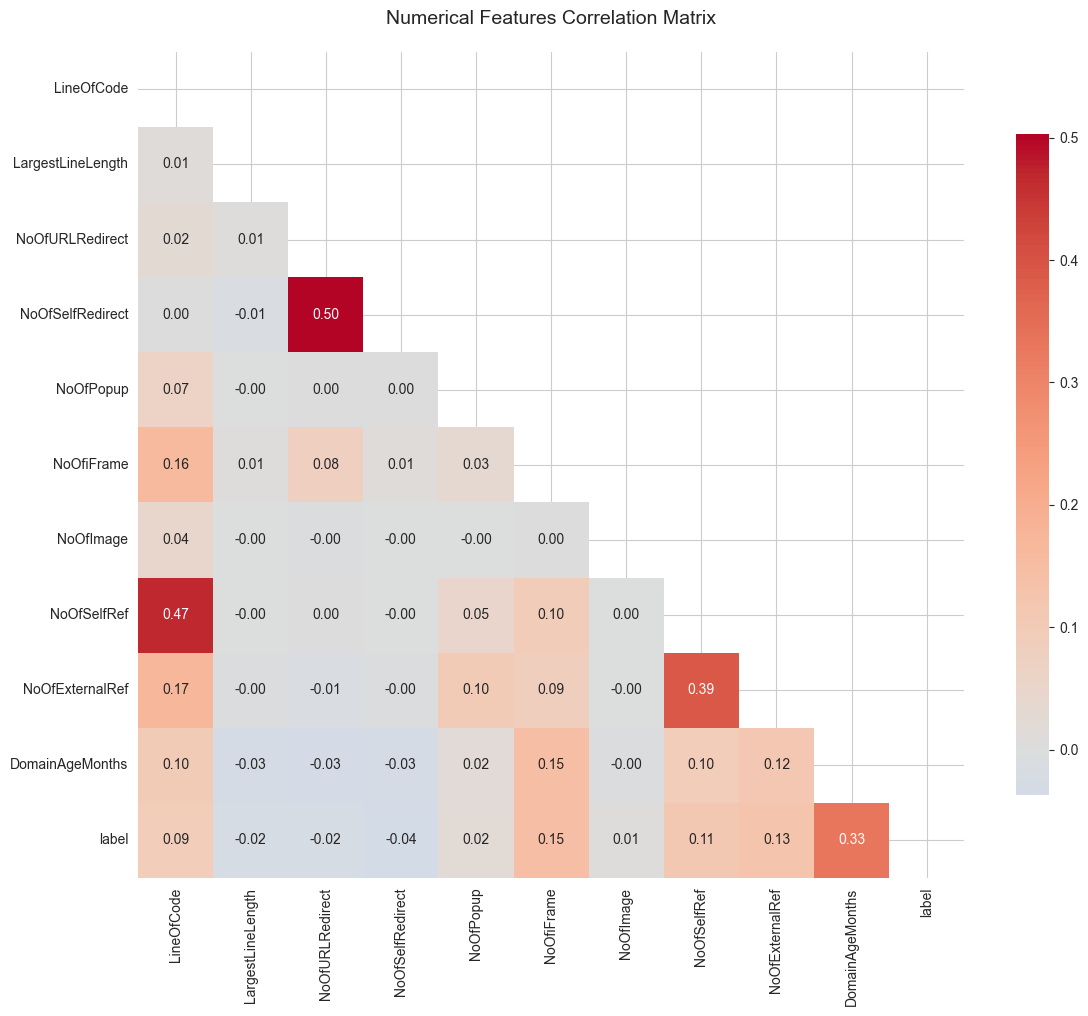

=== CORRELATION WITH TARGET (label) ===
DomainAgeMonths: 0.333 (Higher values indicate Legitimate)
NoOfiFrame: 0.150 (Higher values indicate Legitimate)
NoOfExternalRef: 0.128 (Higher values indicate Legitimate)
NoOfSelfRef: 0.114 (Higher values indicate Legitimate)
LineOfCode: 0.093 (Higher values indicate Legitimate)
NoOfPopup: 0.023 (Higher values indicate Legitimate)
NoOfImage: 0.009 (Higher values indicate Legitimate)
LargestLineLength: -0.023 (Higher values indicate Phishing)
NoOfURLRedirect: -0.024 (Higher values indicate Phishing)
NoOfSelfRedirect: -0.037 (Higher values indicate Phishing)


In [55]:
def analyze_numerical_correlations(df, numerical_columns):
    """
    Analyze correlations between numerical features and with target variable
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    # Select numerical features including target
    analysis_columns = numerical_columns + ['label']
    corr_matrix = df[analysis_columns].corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f', cbar_kws={"shrink": .8})
    plt.title('Numerical Features Correlation Matrix', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()
    
    # Get top correlations with target
    target_correlations = corr_matrix['label'].sort_values(ascending=False)
    print("=== CORRELATION WITH TARGET (label) ===")
    for feature, corr in target_correlations.items():
        if feature != 'label':
            direction = "Legitimate" if corr > 0 else "Phishing"
            print(f"{feature}: {corr:.3f} (Higher values indicate {direction})")
    
    return corr_matrix

# Usage
numerical_features = ['LineOfCode', 'LargestLineLength', 'NoOfURLRedirect', 
                     'NoOfSelfRedirect', 'NoOfPopup', 'NoOfiFrame', 
                     'NoOfImage', 'NoOfSelfRef', 'NoOfExternalRef', 'DomainAgeMonths']
corr_matrix = analyze_numerical_correlations(df, numerical_features)


=== Industry vs TARGET ANALYSIS ===
               Phishing  Legitimate  Phishing_Ratio  Count
Industry                                                  
Banking        0.643939    0.356061        0.643939    264
eCommerce      0.569820    0.430180        0.569820    444
eCommerce      0.543832    0.456168        0.543832   2521
Unknown        0.531812    0.468188        0.531812   1446
Education      0.450875    0.549125        0.450875   1486
Healthcare     0.382979    0.617021        0.382979    423
Manufacturing  0.378419    0.621581        0.378419    658
Fashion        0.370679    0.629321        0.370679    839
Government     0.338858    0.661142        0.338858    543
Non-profit     0.313291    0.686709        0.313291   1580
Food           0.293919    0.706081        0.293919    296


<Figure size 1000x600 with 0 Axes>

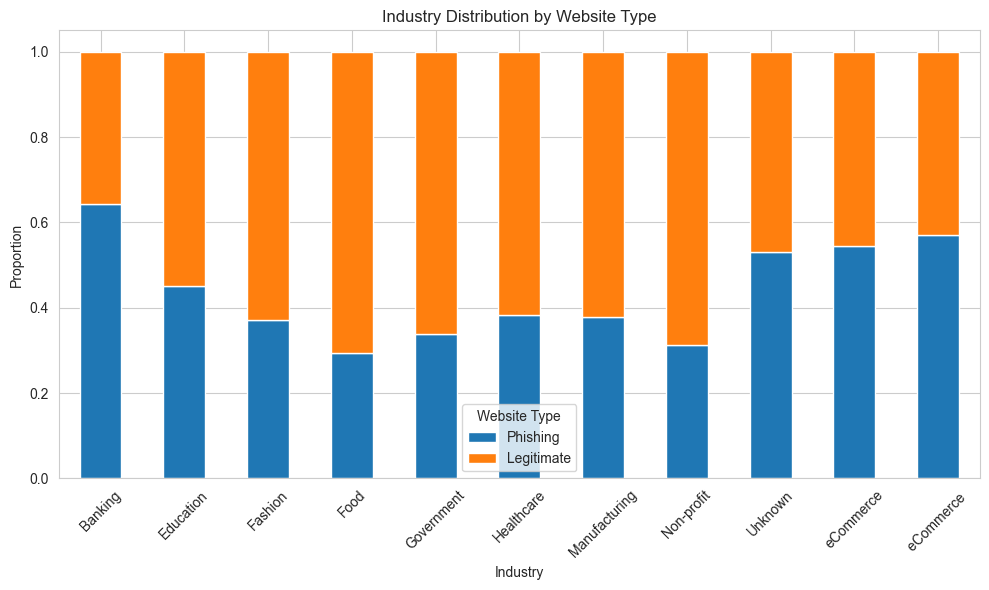


=== HostingProvider vs TARGET ANALYSIS ===
                  Phishing  Legitimate  Phishing_Ratio  Count
HostingProvider                                              
Freehostia        0.725466    0.274534        0.725466    805
InfinityFree      0.722656    0.277344        0.722656    768
000webhost        0.698454    0.301546        0.698454    776
Unknown Provider  0.634664    0.365336        0.634664   1177
Hostinger         0.540656    0.459344        0.540656    701
Namecheap         0.533033    0.466967        0.533033    666
DreamHost         0.525368    0.474632        0.525368    611
GoDaddy           0.312766    0.687234        0.312766    940
HostGator         0.249718    0.750282        0.249718    885
Bluehost          0.246696    0.753304        0.246696    908
AWS               0.238727    0.761273        0.238727    754
Azure             0.215818    0.784182        0.215818    746
Google Cloud      0.207077    0.792923        0.207077    763


<Figure size 1000x600 with 0 Axes>

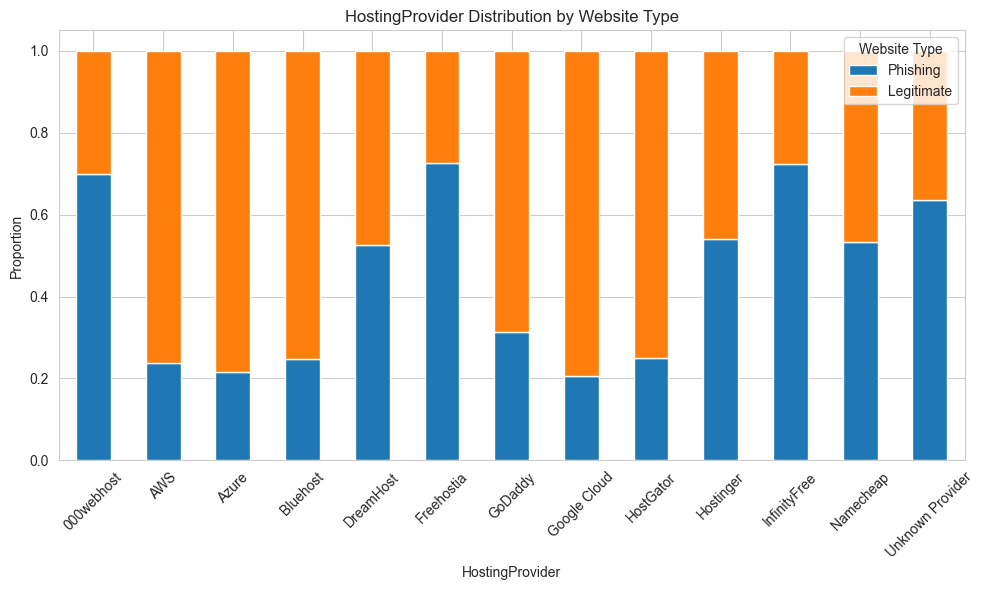


=== Robots vs TARGET ANALYSIS ===
        Phishing  Legitimate  Phishing_Ratio  Count
Robots                                             
0       0.521385    0.478615        0.521385   7739
1       0.248461    0.751539        0.248461   2761


<Figure size 1000x600 with 0 Axes>

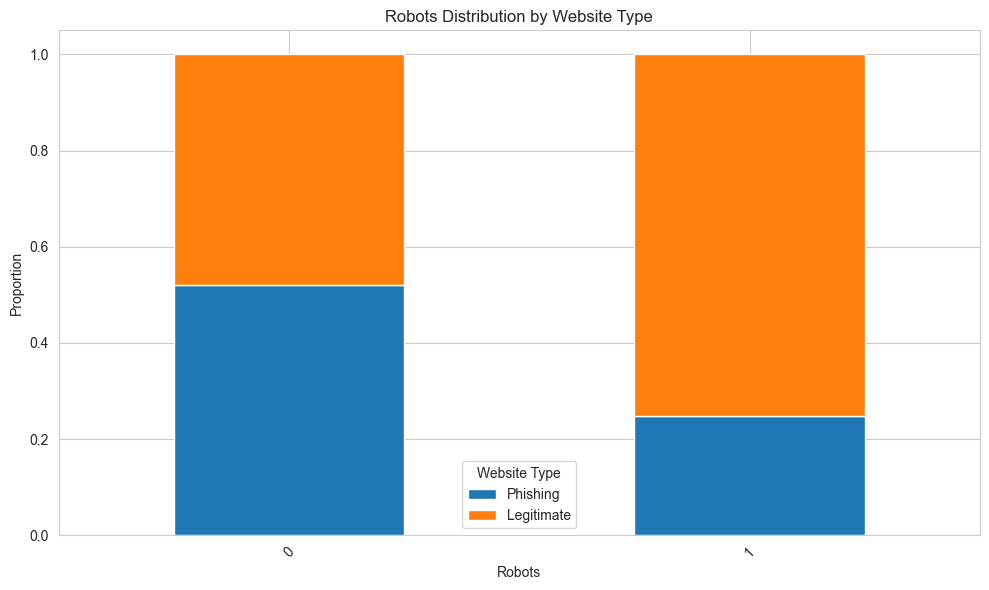


=== IsResponsive vs TARGET ANALYSIS ===
              Phishing  Legitimate  Phishing_Ratio  Count
IsResponsive                                             
0             0.660931    0.339069        0.660931   3952
1             0.322083    0.677917        0.322083   6548


<Figure size 1000x600 with 0 Axes>

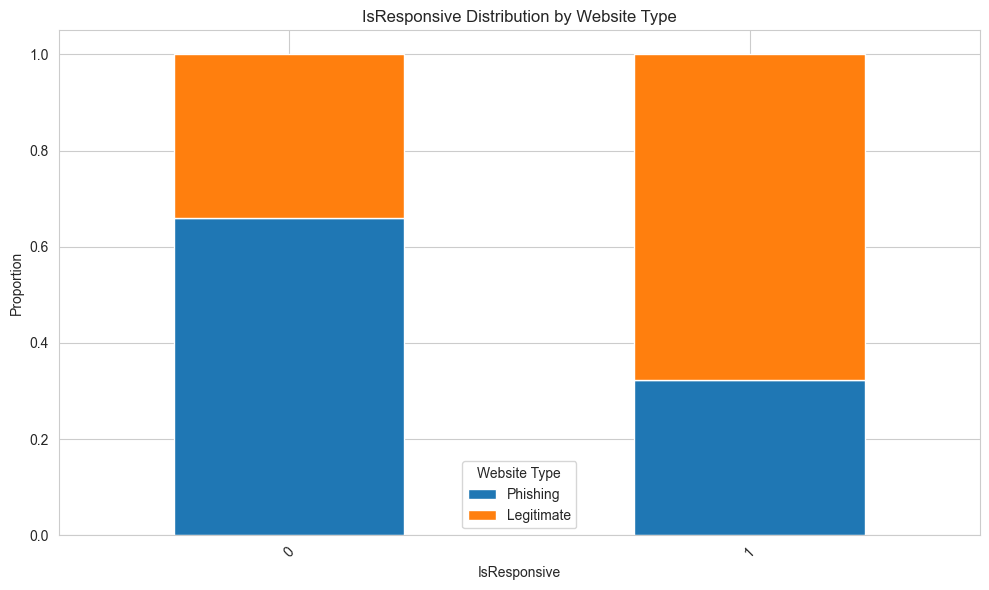

In [57]:
def analyze_categorical_vs_target(df, categorical_columns):
    """
    Analyze relationship between categorical features and target variable
    """
    results = {}
    
    for col in categorical_columns:
        print(f"\n=== {col} vs TARGET ANALYSIS ===")
        
        # Cross tabulation
        cross_tab = pd.crosstab(df[col], df['label'], normalize='index')
        cross_tab.columns = ['Phishing', 'Legitimate']
        
        # Calculate phishing ratio
        cross_tab['Phishing_Ratio'] = cross_tab['Phishing']
        cross_tab['Count'] = df[col].value_counts()
        
        print(cross_tab.sort_values('Phishing_Ratio', ascending=False))
        
        # Visualize
        plt.figure(figsize=(10, 6))
        cross_tab[['Phishing', 'Legitimate']].plot(kind='bar', stacked=True)
        plt.title(f'{col} Distribution by Website Type')
        plt.ylabel('Proportion')
        plt.legend(title='Website Type')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        results[col] = cross_tab
    
    return results

# Usage
categorical_features = ['Industry', 'HostingProvider', 'Robots', 'IsResponsive']
cat_results = analyze_categorical_vs_target(df, categorical_features)

=== NUMERICAL FEATURE DISTRIBUTION BY TARGET ===

--- LineOfCode ---
Phishing sites:
  Mean: 542.85, Median: 37.00
  Std: 1924.66, Range: [2, 61048]
Legitimate sites:
  Mean: 1718.44, Median: 888.00
  Std: 6686.45, Range: [2, 418650]
Mann-Whitney U test p-value: nan
Effect size (Cohen's d): 0.239


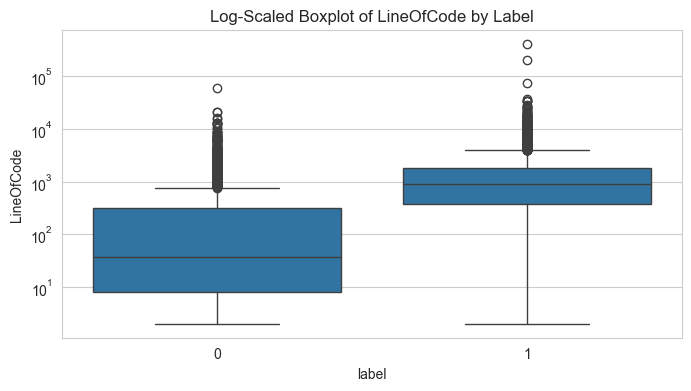

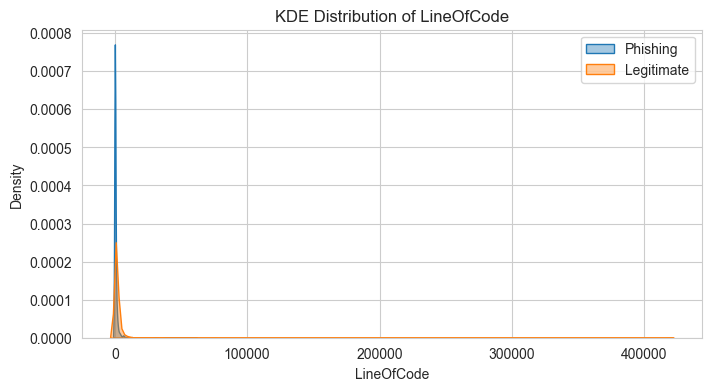


--- LargestLineLength ---
Phishing sites:
  Mean: 13556.22, Median: 273.00
  Std: 110968.79, Range: [22, 3281151]
Legitimate sites:
  Mean: 9271.45, Median: 2333.00
  Std: 77755.02, Range: [22, 4336498]
Mann-Whitney U test p-value: 0.0000
Effect size (Cohen's d): -0.045


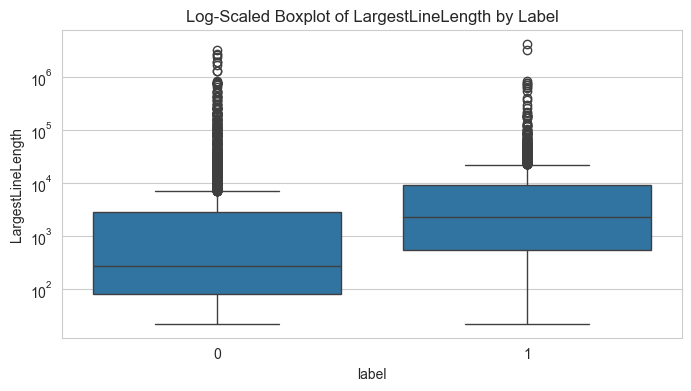

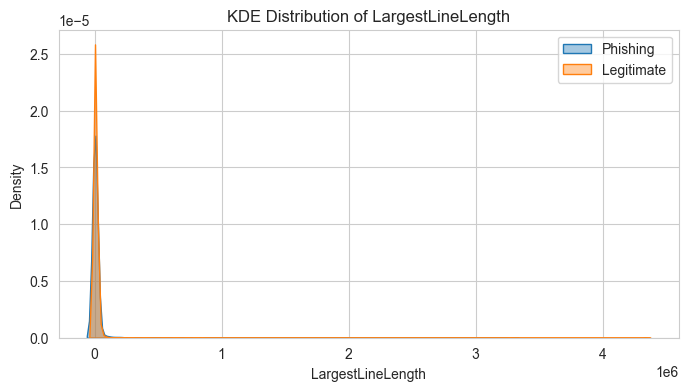


--- NoOfURLRedirect ---
Phishing sites:
  Mean: 0.15, Median: 0.00
  Std: 0.35, Range: [0, 1]
Legitimate sites:
  Mean: 0.13, Median: 0.00
  Std: 0.34, Range: [0, 1]
Mann-Whitney U test p-value: 0.0133
Effect size (Cohen's d): -0.048


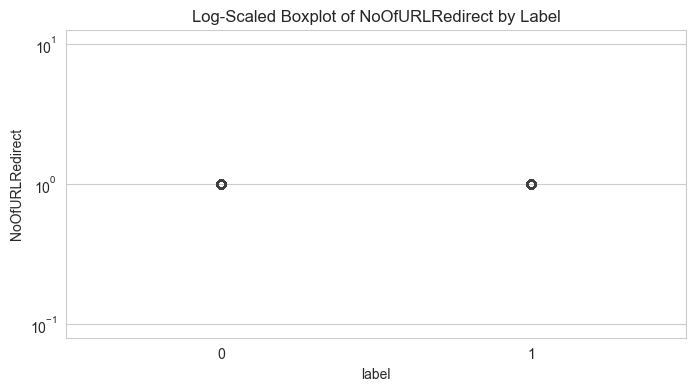

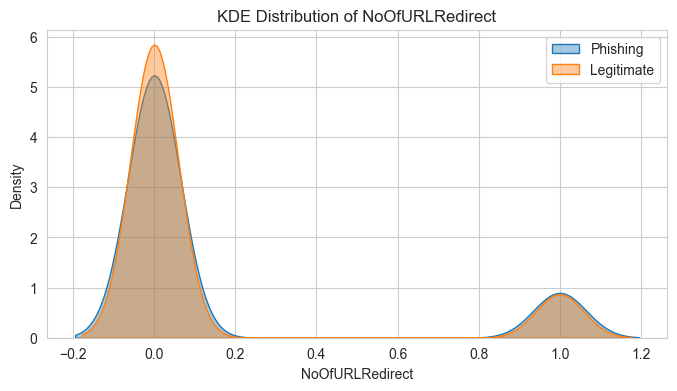


--- NoOfSelfRedirect ---
Phishing sites:
  Mean: 0.05, Median: 0.00
  Std: 0.21, Range: [0, 1]
Legitimate sites:
  Mean: 0.03, Median: 0.00
  Std: 0.18, Range: [0, 1]
Mann-Whitney U test p-value: 0.0001
Effect size (Cohen's d): -0.074


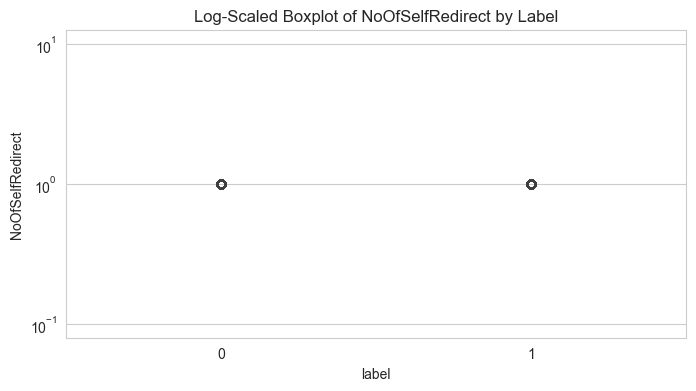

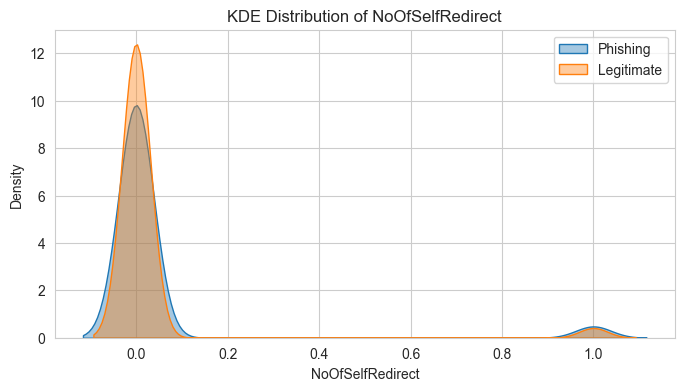


--- NoOfPopup ---
Phishing sites:
  Mean: 0.08, Median: 0.00
  Std: 0.89, Range: [0, 30]
Legitimate sites:
  Mean: 0.35, Median: 0.00
  Std: 7.64, Range: [0, 564]
Mann-Whitney U test p-value: 0.0000
Effect size (Cohen's d): 0.049


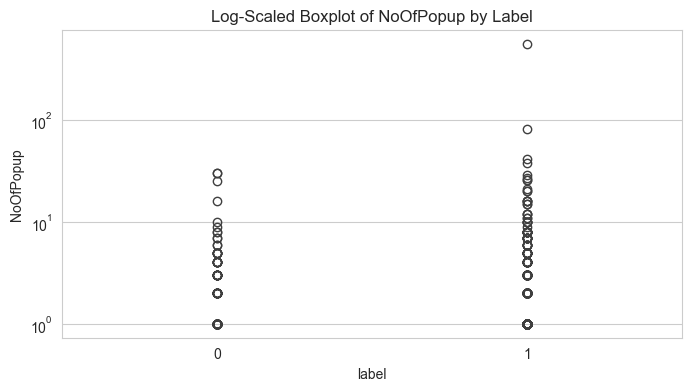

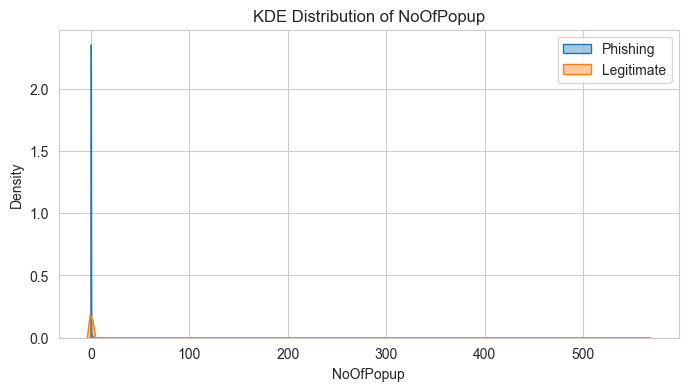


--- NoOfiFrame ---
Phishing sites:
  Mean: 0.84, Median: 0.00
  Std: 4.20, Range: [0, 131]
Legitimate sites:
  Mean: 2.35, Median: 0.00
  Std: 5.50, Range: [0, 120]
Mann-Whitney U test p-value: 0.0000
Effect size (Cohen's d): 0.308


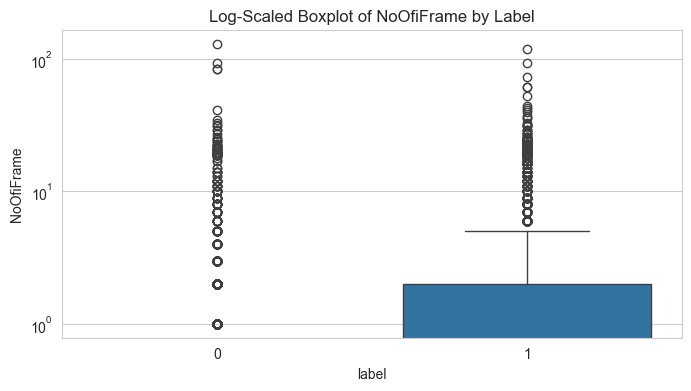

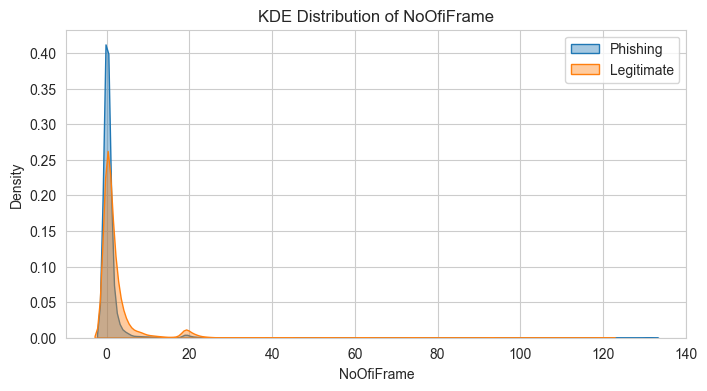


--- NoOfImage ---
Phishing sites:
  Mean: 10.68, Median: 0.00
  Std: 42.38, Range: [-35, 914]
Legitimate sites:
  Mean: 582.26, Median: 18.00
  Std: 41646.73, Range: [-35, 3166000]
Mann-Whitney U test p-value: 0.0000
Effect size (Cohen's d): 0.019


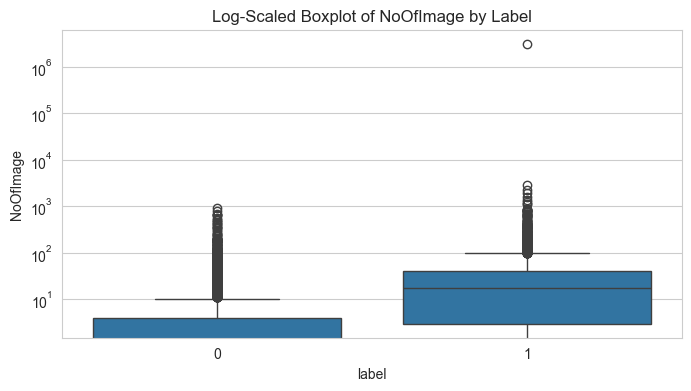

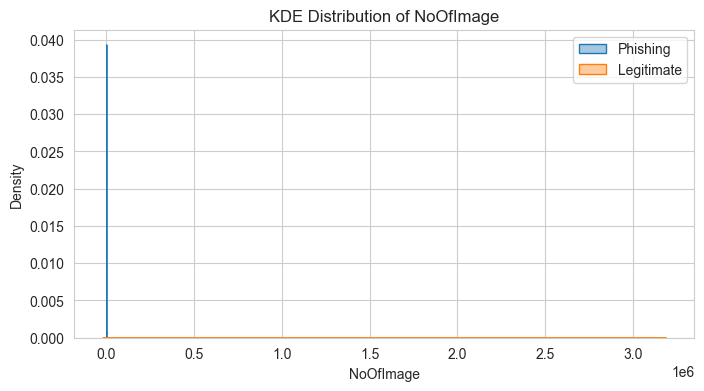


--- NoOfSelfRef ---
Phishing sites:
  Mean: 28.46, Median: 0.00
  Std: 117.95, Range: [0, 4191]
Legitimate sites:
  Mean: 101.29, Median: 58.00
  Std: 410.46, Range: [0, 26596]
Mann-Whitney U test p-value: 0.0000
Effect size (Cohen's d): 0.241


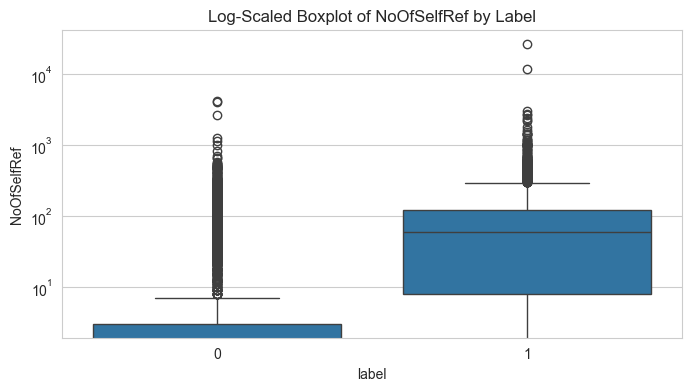

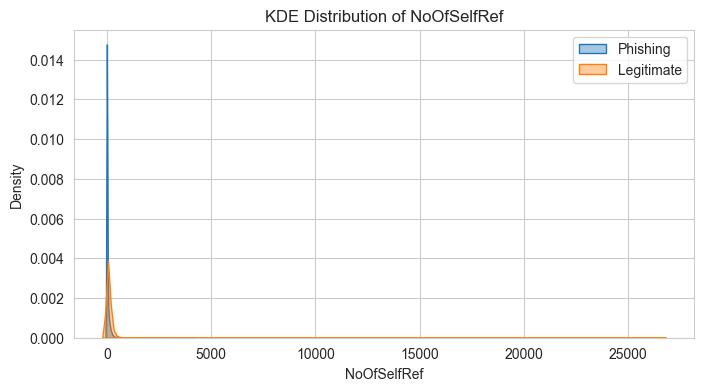


--- NoOfExternalRef ---
Phishing sites:
  Mean: 22.11, Median: 1.00
  Std: 94.69, Range: [0, 4142]
Legitimate sites:
  Mean: 74.88, Median: 31.00
  Std: 260.22, Range: [0, 12353]
Mann-Whitney U test p-value: 0.0000
Effect size (Cohen's d): 0.269


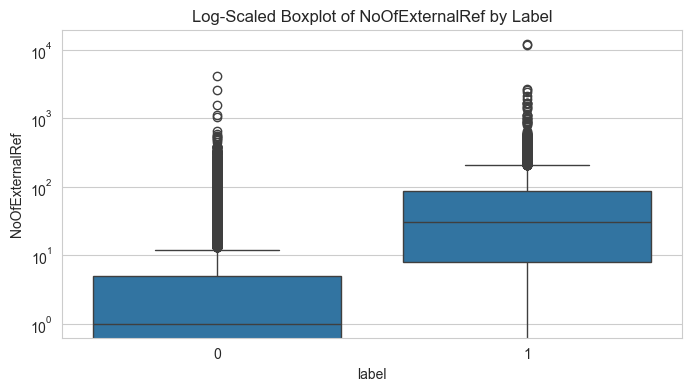

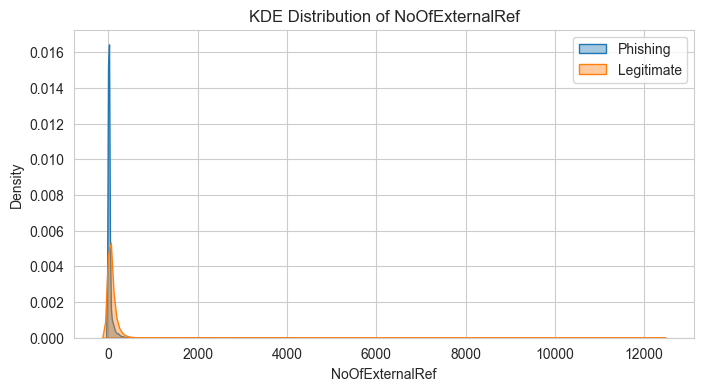


--- DomainAgeMonths ---
Phishing sites:
  Mean: 21.13, Median: 8.00
  Std: 27.55, Range: [0, 120]
Legitimate sites:
  Mean: 43.01, Median: 39.00
  Std: 33.28, Range: [0, 120]
Mann-Whitney U test p-value: 0.0000
Effect size (Cohen's d): 0.716


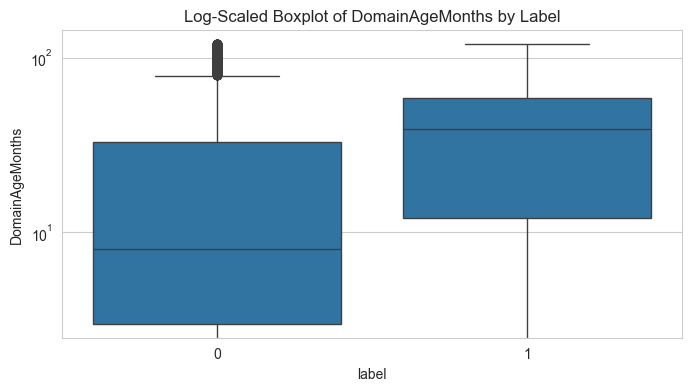

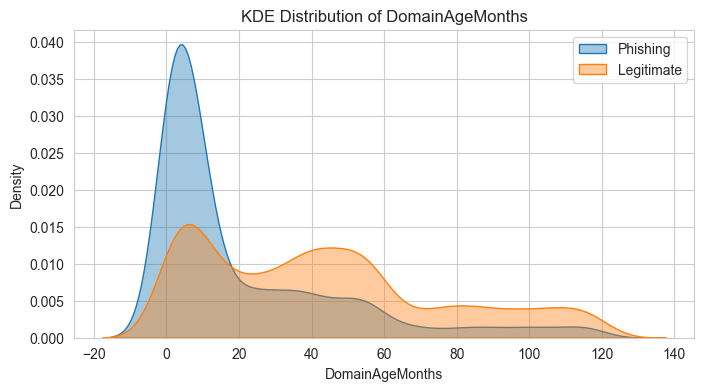

In [87]:
def analyze_numerical_by_target(df, numerical_columns):
    """
    Compare numerical feature distributions between phishing and legitimate sites
    """
    import scipy.stats as stats
    
    print("=== NUMERICAL FEATURE DISTRIBUTION BY TARGET ===")
    
    distribution_results = {}
    
    for col in numerical_columns:
        print(f"\n--- {col} ---")
        
        # Split by target
        phishing_data = df[df['label'] == 0][col]
        legitimate_data = df[df['label'] == 1][col]
        
        # Descriptive statistics
        print("Phishing sites:")
        print(f"  Mean: {phishing_data.mean():.2f}, Median: {phishing_data.median():.2f}")
        print(f"  Std: {phishing_data.std():.2f}, Range: [{phishing_data.min():.0f}, {phishing_data.max():.0f}]")
        
        print("Legitimate sites:")
        print(f"  Mean: {legitimate_data.mean():.2f}, Median: {legitimate_data.median():.2f}")
        print(f"  Std: {legitimate_data.std():.2f}, Range: [{legitimate_data.min():.0f}, {legitimate_data.max():.0f}]")
        
        # Statistical test
        t_stat, p_value = stats.mannwhitneyu(phishing_data, legitimate_data, alternative='two-sided')
        print(f"Mann-Whitney U test p-value: {p_value:.4f}")
        
        # Effect size (Cohen's d)
        cohen_d = (legitimate_data.mean() - phishing_data.mean()) / np.sqrt(
            (legitimate_data.std()**2 + phishing_data.std()**2) / 2
        )
        print(f"Effect size (Cohen's d): {cohen_d:.3f}")
        
        # Visualization
        plt.figure(figsize=(8, 4))
        sns.boxplot(data=df, x="label", y=col)
        plt.yscale("log")
        plt.title(f"Log-Scaled Boxplot of {col} by Label")
        plt.show()

        plt.figure(figsize=(8, 4))
        sns.kdeplot(df[df['label'] == 0][col], label='Phishing', fill=True, alpha=0.4)
        sns.kdeplot(df[df['label'] == 1][col], label='Legitimate', fill=True, alpha=0.4)
        plt.title(f"KDE Distribution of {col}")
        plt.legend()
        plt.show() 
        
        distribution_results[col] = {
            'p_value': p_value,
            'cohen_d': cohen_d,
            'significant': p_value < 0.05,
            'effect_size': abs(cohen_d)
        }
    
    return distribution_results

# Usage
numerical_results = analyze_numerical_by_target(df, numerical_features)

In [ ]:
def rank_numerical_features(df, numerical_columns):
    """
    Rank numerical features using Cohen's d effect size and correlation
    """
    import scipy.stats as stats
    from scipy.stats import norm
    
    print("=== NUMERICAL FEATURES IMPORTANCE RANKING ===")
    
    numerical_importance = {}
    
    for feature in numerical_columns:
        if feature == 'label':
            continue
            
        # Split data by target
        phishing_data = df[df['label'] == 0][feature].dropna()
        legitimate_data = df[df['label'] == 1][feature].dropna()
        
        # Calculate Cohen's d for effect size
        n1, n2 = len(phishing_data), len(legitimate_data)
        mean1, mean2 = phishing_data.mean(), legitimate_data.mean()
        std1, std2 = phishing_data.std(), legitimate_data.std()
        
        # Pooled standard deviation
        pooled_std = np.sqrt(((n1 - 1) * std1 ** 2 + (n2 - 1) * std2 ** 2) / (n1 + n2 - 2))
        
        if pooled_std == 0:
            cohen_d = 0
        else:
            cohen_d = (mean2 - mean1) / pooled_std  # Positive d means legitimate > phishing
        
        # Absolute effect size for ranking
        abs_cohen_d = abs(cohen_d)
        
        # Correlation with target
        corr_with_target = abs(df[feature].corr(df['label']))
        
        # Statistical significance (Mann-Whitney U test)
        try:
            _, p_value = stats.mannwhitneyu(phishing_data, legitimate_data, alternative='two-sided')
        except:
            p_value = 1.0
        
        # Feature variability (important for model stability)
        coefficient_of_variation = df[feature].std() / df[feature].mean() if df[feature].mean() != 0 else 0
        
        # Combined importance score (Cohen's d weighted more heavily)
        # Cohen's d measures standardized difference between groups
        # Correlation measures linear relationship strength
        importance_score = (abs_cohen_d * 0.7) + (corr_with_target * 0.3)
        
        numerical_importance[feature] = {
            'cohen_d': cohen_d,
            'abs_cohen_d': abs_cohen_d,
            'correlation': corr_with_target,
            'p_value': p_value,
            'significant': p_value < 0.05,
            'cv': coefficient_of_variation,
            'phishing_mean': mean1,
            'legitimate_mean': mean2,
            'importance_score': importance_score,
            'effect_direction': 'Legitimate > Phishing' if cohen_d > 0 else 'Phishing > Legitimate'
        }
    
    # Rank numerical features by importance score
    ranked_numerical = sorted(numerical_importance.items(), 
                            key=lambda x: x[1]['importance_score'], 
                            reverse=True)
    
    print("\nTOP NUMERICAL FEATURES BY IMPORTANCE:")
    print("Rank | Feature                | Cohen's d | Corr  | p-value | Direction")
    print("-" * 75)
    for i, (feature, scores) in enumerate(ranked_numerical, 1):
        significance = "***" if scores['p_value'] < 0.001 else "**" if scores['p_value'] < 0.01 else "*" if scores['p_value'] < 0.05 else ""
        print(f"{i:4d} | {feature:22} | {scores['abs_cohen_d']:8.3f} | {scores['correlation']:5.3f} | {scores['p_value']:7.4f}{significance} | {scores['effect_direction']}")
    
    return numerical_importance, ranked_numerical

# Usage
numerical_importance, ranked_numerical = rank_numerical_features(df, numerical_features)

=== NUMERICAL FEATURES IMPORTANCE RANKING ===

TOP NUMERICAL FEATURES BY IMPORTANCE:
Rank | Feature                | Cohen's d | Corr  | p-value | Direction
---------------------------------------------------------------------------
   1 | DomainAgeMonths        |    0.711 | 0.334 |  0.0000*** | Legitimate > Phishing
   2 | NoOfiFrame             |    0.310 | 0.153 |  0.0000*** | Legitimate > Phishing
   3 | LineOfCode             |    0.280 | 0.138 |  0.0000*** | Legitimate > Phishing
   4 | NoOfExternalRef        |    0.259 | 0.128 |  0.0000*** | Legitimate > Phishing
   5 | NoOfSelfRef            |    0.229 | 0.113 |  0.0000*** | Legitimate > Phishing
   6 | NoOfSelfRedirect       |    0.077 | 0.038 |  0.0001*** | Phishing > Legitimate
   7 | NoOfURLRedirect        |    0.050 | 0.025 |  0.0126* | Phishing > Legitimate
   8 | NoOfPopup              |    0.048 | 0.024 |  0.0000*** | Legitimate > Phishing
   9 | LargestLineLength      |    0.045 | 0.022 |  0.0000*** | Phishing > Legiti

In [79]:
def rank_categorical_features(df, categorical_columns):
    """
    Rank categorical features using Cramer's V effect size and chi-square tests
    """
    from scipy.stats import chi2_contingency
    
    print("\n=== CATEGORICAL FEATURES IMPORTANCE RANKING ===")
    
    categorical_importance = {}
    
    for feature in categorical_columns:
        # Create contingency table
        contingency_table = pd.crosstab(df[feature], df['label'])
        
        # Chi-square test for independence
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        
        # Cramer's V for effect size (adjusted for table dimensions)
        n = contingency_table.sum().sum()
        min_dim = min(contingency_table.shape) - 1
        cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0
        
        # Information Value (IV) for predictive power
        from sklearn.feature_selection import mutual_info_classif
        
        # Encode categorical variable for mutual information
        feature_encoded = pd.factorize(df[feature])[0]
        mutual_info = mutual_info_classif(feature_encoded.reshape(-1, 1), 
                                        df['label'], 
                                        random_state=42)[0]
        
        # Phishing ratio variability across categories
        category_stats = []
        for category in df[feature].unique():
            category_data = df[df[feature] == category]
            phishing_ratio = (category_data['label'] == 0).mean()
            category_stats.append(phishing_ratio)
        
        variability = np.std(category_stats)  # Higher std means better discrimination
        
        # Combined importance score
        importance_score = (cramers_v * 0.5) + (mutual_info * 0.3) + (variability * 0.2)
        
        categorical_importance[feature] = {
            'cramers_v': cramers_v,
            'mutual_info': mutual_info,
            'chi2_pvalue': p_value,
            'variability': variability,
            'n_categories': df[feature].nunique(),
            'significant': p_value < 0.05,
            'importance_score': importance_score
        }
    
    # Rank categorical features by importance score
    ranked_categorical = sorted(categorical_importance.items(), 
                              key=lambda x: x[1]['importance_score'], 
                              reverse=True)
    
    print("\nTOP CATEGORICAL FEATURES BY IMPORTANCE:")
    print("Rank | Feature                | Cramer's V | MI     | p-value  | Categories")
    print("-" * 75)
    for i, (feature, scores) in enumerate(ranked_categorical, 1):
        significance = "***" if scores['chi2_pvalue'] < 0.001 else "**" if scores['chi2_pvalue'] < 0.01 else "*" if scores['chi2_pvalue'] < 0.05 else ""
        print(f"{i:4d} | {feature:22} | {scores['cramers_v']:9.3f} | {scores['mutual_info']:6.3f} | {scores['chi2_pvalue']:8.4f}{significance} | {scores['n_categories']:3d}")
    
    return categorical_importance, ranked_categorical

# Usage
categorical_importance, ranked_categorical = rank_categorical_features(df, categorical_features)


=== CATEGORICAL FEATURES IMPORTANCE RANKING ===

TOP CATEGORICAL FEATURES BY IMPORTANCE:
Rank | Feature                | Cramer's V | MI     | p-value  | Categories
---------------------------------------------------------------------------
   1 | HostingProvider        |     0.407 |  0.085 |   0.0000*** |  13
   2 | IsResponsive           |     0.330 |  0.069 |   0.0000*** |   2
   3 | Robots                 |     0.241 |  0.028 |   0.0000*** |   2
   4 | Industry               |     0.198 |  0.021 |   0.0000*** |  11


Top Predictors Selection for Phishing Detection
Based on the comprehensive feature importance analysis, here are the selected top predictors:

Tier 1: High-Impact Predictors (Cohen's d ≥ 0.25 / Cramer's V ≥ 0.25)
Numerical Features:
DomainAgeMonths (d=0.711) - Primary Predictor

Strongest discriminator with large effect size

Legitimate sites are significantly older

Critical for model performance

NoOfiFrame (d=0.310) - Key Technical Indicator

Medium effect size, highly significant

Legitimate sites use more iframes (possibly for legitimate embeds)

LineOfCode (d=0.280) - Code Complexity Metric

Legitimate sites have more complex code structure

Medium effect size with strong statistical significance

NoOfExternalRef (d=0.259) - External Link Behavior

Legitimate sites reference more external resources

Medium effect size, highly significant

Categorical Features:
HostingProvider (V=0.407) - Infrastructure Signal

Strongest categorical predictor

Certain providers associated with legitimate/phishing patterns

High discriminatory power

IsResponsive (V=0.330) - Website Quality Indicator

Medium-strong association

Responsive design correlates with legitimate sites

Important user experience metric

Tier 2: Moderate Predictors (Cohen's d 0.10-0.25 / Cramer's V 0.15-0.25)
NoOfSelfRef (d=0.229) - Internal Link Structure

Legitimate sites have more internal navigation

Small-medium effect, highly significant

Robots (V=0.241) - SEO & Professionalism

Presence of robots.txt indicates legitimate site

Small-medium association, highly significant

Industry (V=0.198) - Business Context

Certain industries more targeted by phishing

Small-medium association, highly significant

Tier 3: Supplementary Predictors (Cohen's d < 0.10)
NoOfSelfRedirect (d=0.077) - Navigation Pattern

Phishing sites use slightly more self-redirects

Small effect but statistically significant

In [ ]:
TOP_4_FEATURES = [
    'DomainAgeMonths',      # Best numerical
    'HostingProvider',      # Best categorical
    'NoOfiFrame',          # 2nd best numerical  
    'IsResponsive'         # 2nd best categorical 
]



in numerical analysis the Cohen's d's value is different
clear df/df_clean/df_final etc
clean anything that is unnecessary (the plot that doesnt really give much insights)
there are a lot outlier for many numerical feature, is that for sure that i dont need to deal with them

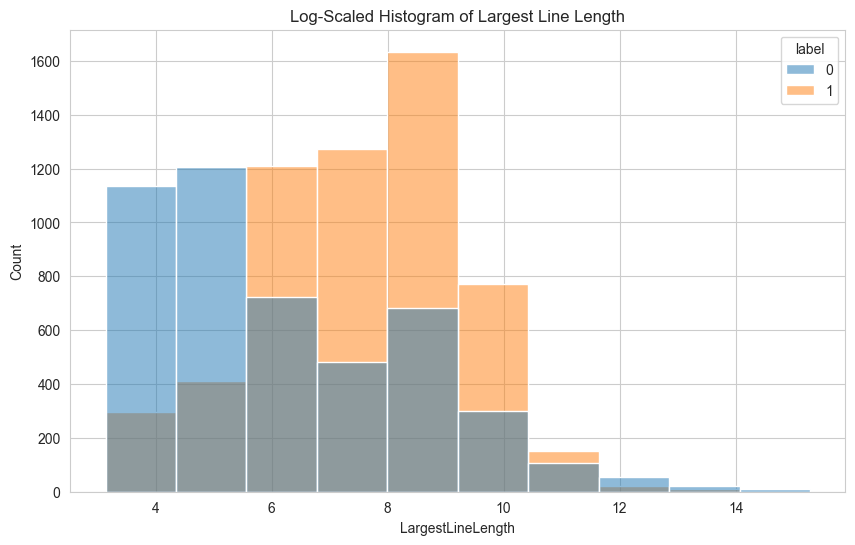

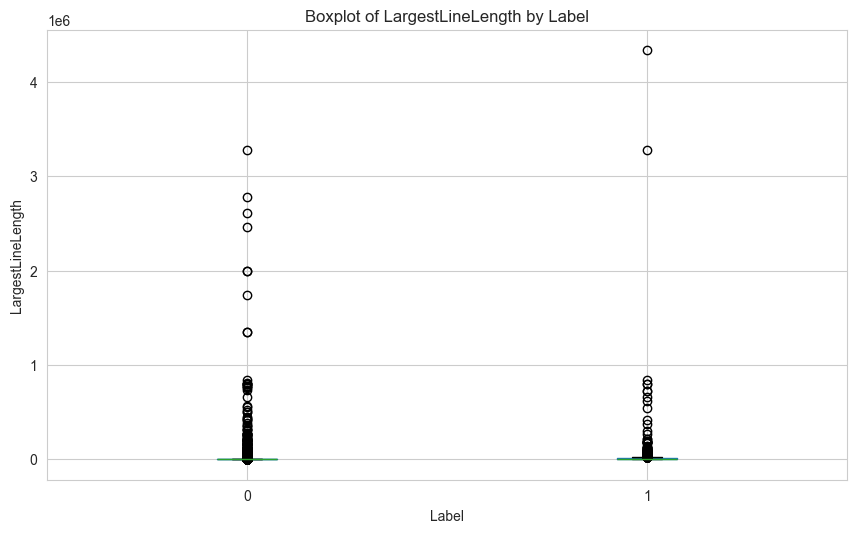

In [88]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x=np.log1p(df["LargestLineLength"]), hue="label", bins=10)
plt.title("Log-Scaled Histogram of Largest Line Length")
plt.show()

df.boxplot(column='LargestLineLength', by='label')
plt.title("Boxplot of LargestLineLength by Label")
plt.suptitle("")  # remove automatic subtitle
plt.xlabel("Label")
plt.ylabel("LargestLineLength")
plt.show()
